In [ ]:
import sys
import numpy as np
import torch
import pandas as pd
import scanpy as sc
from anndata import read_h5ad


In [ ]:
ont_dir = '/data/yosef2/users/chenling/cellontology/'
sys.path.append(ont_dir)

# Data loading

In [ ]:
data_path = "/data/yosef2/users/chenling/TabulaSapiensData/combined/Pilot1_Pilot2.Final.h5ad"
adjm_path = "./data/ontology.flat.pkl"

In [ ]:
annd = read_h5ad(data_path)

batch_idx = annd.obs["donor"]
labels = annd.obs["manual_cell_ontology_class"]

In [ ]:
import pickle

adj = pickle.load(open(adjm_path, "rb" ) )
adjm = adj.adjacency_matrix()

In [ ]:
def get_direct_desc(series):
    """
        return list of direct descendants
    """
    return list(series[lambda y: y == 1].index.values)

def _recursor(nodes, adjm, depth):
#     print(nodes, depth)
    desc_of_nodes = list(adjm[depth].loc[nodes].apply(get_direct_desc, axis=1))
    concat_desc = [item for sublist in desc_of_nodes for item in sublist]
#     print(concat_desc)
    if depth == len(adjm) - 1:
        return concat_desc
    else:
        return _recursor(
            nodes=concat_desc,
            adjm=adjm,
            depth=depth+1
        )
    
def get_node_to_leaves(adjm):
    depth_lvls = len(adjm)
    mapper = []
    for depth_lvl in range(depth_lvls):
        nodes = adjm[depth_lvl].index.values
        _nodes = pd.Series([[idx] for idx in adjm[depth_lvl].index])
        leaves = _nodes.apply(_recursor, adjm=adjm, depth=depth_lvl)
        ser = pd.Series(data=leaves.values, index=nodes)
        mapper.append(ser)
    
    leaves = adjm[-1].columns.values
    _leaves = [[leaf] for leaf in leaves]
    mapper.append(
        pd.Series(data=_leaves, index=leaves)
    )
    res = pd.concat(mapper)
    res.loc["unassigned"] = ["unassigned"]
    res.loc["low_quality"] = ["low_quality"]
    return res


def get_names(all_to_leaves, adj):
    id_to_label = {
        idx: adj.nodes[idx]['name'] for idx in all_to_leaves.index 
        if (idx != "unassigned")  and (idx != "low_quality")
    }
    label_to_id = {
        adj.nodes[idx]['name']: idx for idx in all_to_leaves.index 
        if (idx != "unassigned") and (idx != "low_quality")
    }
   
    id_to_label = pd.Series(id_to_label)
    label_to_id = pd.Series(label_to_id)
    id_to_label.loc["unassigned"] = "unassigned"
    label_to_id.loc["unassigned"] = "unassigned"
    
    id_to_label.loc["low_quality"] = "low_quality"
    label_to_id.loc["low_quality"] = "low_quality"
    return id_to_label, label_to_id

def get_to_idx_mappers(leaf_node_names, other_node_names):
    total_nb = len(leaf_node_names) + len(other_node_names)
    
    data = leaf_node_names + other_node_names
    index = np.arange(total_nb)
    idx_to_node = pd.Series(
        data=data, index=index
    )
    node_to_idx = pd.Series(
        data=index, index=data
    )
    return node_to_idx, idx_to_node

In [ ]:
all_to_leaves = get_node_to_leaves(adjm)
print(len(all_to_leaves))
all_to_leaves.head()

leaf_node_names = list(adjm[-1].columns.values) + ["low_quality"] + ["unassigned"]
other_node_names = list(all_to_leaves.index[~np.isin(all_to_leaves.index, leaf_node_names)])
print(len(other_node_names) + len(leaf_node_names))

In [ ]:
id_to_label, label_to_id = get_names(all_to_leaves=all_to_leaves, adj=adj)

In [ ]:
nodes_to_indices, indices_to_nodes = get_to_idx_mappers(
    leaf_node_names=leaf_node_names,
    other_node_names=other_node_names,
)


In [ ]:
# Convert labels like "T-cell" to nodes "CL:0000084"
nodes = label_to_id[labels]
assert len(nodes) == len(labels)
print("Number of nodes that are NaN", nodes.isna().sum())

In [ ]:
node_counts = nodes.groupby(nodes).size()
leaf_counts = node_counts.reindex(leaf_node_names).fillna(1.0)

In [ ]:
def get_leaf_sampling_probs(
    all_to_leaves, leaf_counts, nodes_to_indices
):
    """
        all_to_leaves: map between node names and their leaves
        leaf_counts: empirical counts in the dataset of leaf counts
    """
    nodes_to_leaves_probs = np.zeros(
        (len(all_to_leaves), len(leaf_counts),)
    )
    for label, idx in nodes_to_indices.items():
        leaves = all_to_leaves[label]
        for leaf in leaves:
            nodes_to_leaves_probs[idx, nodes_to_indices[leaf]] = leaf_counts[leaf]
    nodes_to_leaves_probs = nodes_to_leaves_probs / nodes_to_leaves_probs.sum(
        1, keepdims=True
    )
    return nodes_to_leaves_probs

In [ ]:
nodes_to_leaves_probs = get_leaf_sampling_probs(
    all_to_leaves=all_to_leaves, leaf_counts=leaf_counts, nodes_to_indices=nodes_to_indices
)

In [ ]:
%matplotlib inline
import seaborn as sns

sns.heatmap(nodes_to_leaves_probs)

In [ ]:
len(leaf_node_names)

In [ ]:
(nodes_to_leaves_probs[:93][:,:93] == np.eye(93,)).all()

In [ ]:
adjmc = []
for x in adjm:
    a = x.shape[0]
    b = x.shape[1]
    temp = np.zeros((a + 1, b + 1))
    temp[:a, :b] = np.asarray(x)
    temp[a, b] = 1
    adjmc.append(temp)

### Gene selection

In [ ]:
nodes_to_leaves_probs = torch.tensor(nodes_to_leaves_probs, device="cuda")

In [76]:
final_cells = ~nodes.isna().values
# final_cells = np.ones(annd.raw.X.shape[0], dtype=bool)
print(final_cells.mean())

0.9995233719713237


In [67]:
adata2 = sc.AnnData(X=annd.raw.X, var=annd.raw.var, obs = annd.obs)

# sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
# sc.pp.log1p(adata2)

sc.pp.normalize_total(adata2, target_sum=1e4)
# logarithmed data
sc.pp.log1p(adata2)

Highly variable genes: 3000


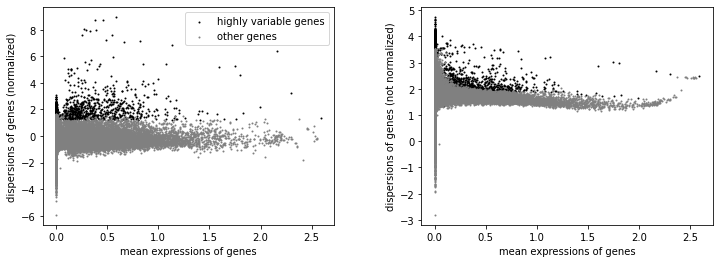

In [68]:
# Finding top genes
sc.pp.highly_variable_genes(
    adata=adata2,
    n_top_genes=3000,
#     flavor=flavor,
    batch_key="donor",
#     **highly_var_genes_kwargs,
)

sc.pl.highly_variable_genes(adata2)
print("Highly variable genes: %d"%sum(adata2.var.highly_variable))

var_genes_all = adata2.var.highly_variable

In [69]:
annd.obs

,10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,cell_id,method,notes,donor,...,n_genes,batch,donor_tech_tissue,donor_tech,compartment,compartment_pred,propagated_cell_ontology_class,manual_cell_ontology_class,propagated_cell_ontology_class_0,manual_cell_ontology_class_0
AAACCCAAGTTGTCGT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,TSP1_blood_2,nan,nan,nan,nan,nan,AAACCCAAGTTGTCGT_TSP1_blood_2,10X,nan,TSP1,...,2056,0,TSP1_10X_Blood,TSP1_10X,unassigned,Immune,"naive thymus-derived CD4-positive, alpha-beta ...",unassigned,"naive thymus-derived CD4-positive, alpha-beta ...",unassigned
AAACGAAAGCCGTTAT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,TSP1_blood_2,nan,nan,nan,nan,nan,AAACGAAAGCCGTTAT_TSP1_blood_2,10X,nan,TSP1,...,1847,0,TSP1_10X_Blood,TSP1_10X,unassigned,Immune,"CD8-positive, alpha-beta memory T cell",unassigned,"CD4-positive, alpha-beta memory T cell",unassigned
AAAGGATAGTGTTGTC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,TSP1_blood_2,nan,nan,nan,nan,nan,AAAGGATAGTGTTGTC_TSP1_blood_2,10X,nan,TSP1,...,2208,0,TSP1_10X_Blood,TSP1_10X,unassigned,Immune,CD4-positive helper T cell,unassigned,"naive thymus-derived CD4-positive, alpha-beta ...",unassigned
AAAGGGCAGGAACTAT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,TSP1_blood_2,nan,nan,nan,nan,nan,AAAGGGCAGGAACTAT_TSP1_blood_2,10X,nan,TSP1,...,2782,0,TSP1_10X_Blood,TSP1_10X,unassigned,Immune,neutrophil,unassigned,neutrophil,unassigned
AAAGGGCCAACCAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,TSP1_blood_2,nan,nan,nan,nan,nan,AAAGGGCCAACCAACT_TSP1_blood_2,10X,nan,TSP1,...,4694,0,TSP1_10X_Blood,TSP1_10X,unassigned,Immune,classical monocyte,unassigned,classical monocyte,unassigned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_P2_S98.homo.gencode.v30.ERCC.chrM-1-1,nan,nan,B133324,nan,nan,B114585,TSP2_Vasculature_aorta_SS2_B114585_B133324_Str...,smartseq2,nan,TSP2,...,2590,3,TSP2_smartseq2_Vasculature,TSP2_smartseq2,unassigned,Stromal,fibroblast,unassigned,fibroblast,unassigned
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_P3_S99.homo.gencode.v30.ERCC.chrM-1-1,nan,nan,B133324,nan,nan,B114585,TSP2_Vasculature_aorta_SS2_B114585_B133324_Str...,smartseq2,nan,TSP2,...,2327,3,TSP2_smartseq2_Vasculature,TSP2_smartseq2,unassigned,Stromal,fibroblast,unassigned,fibroblast,unassigned
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_P7_S103.homo.gencode.v30.ERCC.chrM-1-1,nan,nan,B133324,nan,nan,B114585,TSP2_Vasculature_aorta_SS2_B114585_B133324_Str...,smartseq2,nan,TSP2,...,2411,3,TSP2_smartseq2_Vasculature,TSP2_smartseq2,Stromal,Stromal,fibroblast,unassigned,fibroblast,unassigned
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_P8_S104.homo.gencode.v30.ERCC.chrM-1-1,nan,nan,B133324,nan,nan,B114585,TSP2_Vasculature_aorta_SS2_B114585_B133324_Str...,smartseq2,nan,TSP2,...,1439,3,TSP2_smartseq2_Vasculature,TSP2_smartseq2,unassigned,Immune,T cell,unassigned,plasma cell,unassigned


In [77]:
final_cells

array([ True,  True,  True, ...,  True,  True,  True])

In [78]:
X_final = annd.raw.X[final_cells][:, var_genes_all]
var_final = annd.raw.var[var_genes_all]
obs_final = annd.obs[final_cells]

In [79]:
adataf = sc.AnnData(X=X_final, var=var_final, obs=obs_final)
adataf.obs["batch_indices"] = pd.factorize(adataf.obs['donor'])[0]

In [87]:
a_labels = label_to_id[adataf.obs["manual_cell_ontology_class"].values].values
a_labels = nodes_to_indices[a_labels].values

In [88]:
assert a_labels.shape[0] == adataf.X.shape[0]

In [89]:
adataf.obs["final_labels"] = a_labels

In [90]:
from scvi.dataset import AnnDatasetFromAnnData

In [95]:
train_data = AnnDatasetFromAnnData(
    adataf, 
    batch_label="batch_indices",
    ctype_label="labels"
)

train_data.cell_types = label_to_id.index.values
train_data.labels = a_labels
train_data.n_labels = len(train_data.cell_types)

[2020-07-09 12:17:20,160] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-07-09 12:17:20,171] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-07-09 12:17:20,701] WARNING - scvi.dataset.dataset | X contains continuous and/or negative values. Please use raw UMI/read counts with scVI
[2020-07-09 12:17:20,702] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-07-09 12:17:21,049] INFO - scvi.dataset.dataset | Downsampled from 203416 to 203416 cells


In [96]:
train_data.labels

array([[93],
       [93],
       [93],
       ...,
       [93],
       [93],
       [93]], dtype=uint16)

In [97]:
assert train_data.X.shape[0] == train_data.labels.shape[0]

In [98]:
print("Number of labels:", len(np.unique(train_data.labels)))
print("Number of batches:", len(np.unique(train_data.batch_indices)))

Number of labels: 109
Number of batches: 2


In [101]:
len(train_data)

203416

In [104]:
len(train_data.labels)

203416

In [105]:
len(a_labels)

203416

# Model training

In [106]:
from scvi.models import SCANVI
from scvi.inference import SemiSupervisedTrainer

In [107]:
train_data.labels.ravel()

array([93, 93, 93, ..., 93, 93, 93], dtype=uint16)

In [109]:
unlabelled_idx = 65535
labelled = np.where(train_data.labels.ravel()!= nodes_to_indices.loc["unassigned"])[0]
unlabelled = np.where(train_data.labels.ravel()==nodes_to_indices.loc["unassigned"])[0]

In [110]:
n_labels_final = nodes_to_indices["unassigned"]

In [111]:
scanvi = SCANVI(
    train_data.nb_genes, 
    n_batch=train_data.n_batches, 
    n_labels=n_labels_final, 
    n_layers=3, 
    n_latent=50,
    symmetric_kl=True, 
    use_ontology=True,
    ontology=adjmc,
    dispersion='gene-batch'
)

trainer_scanvi = SemiSupervisedTrainer(
    scanvi, 
    train_data,   
    n_epochs_classifier=50,   
    lr_classification=5 * 1e-3, 
    seed=1,
    batch_size=500,
    n_epochs_kl_warmup=5,
    indices_labelled=labelled,
    indices_unlabelled=unlabelled,
    nodes_to_leaves_probs=nodes_to_leaves_probs,
) 

labelled indices:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  94 130 131 132 137 144 145 154 161 167 184 214 219 222 225 230 241 244]
unlabelled indices:  [93]


In [112]:
trainer_scanvi.train(
    n_epochs=20,
    lr=0.001,
)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19



In [115]:
full = trainer_scanvi.create_posterior(trainer_scanvi.model, train_data, indices=np.arange(len(train_data)))
_, pred = full.sequential().compute_predictions()

latent, _, _ = full.sequential().get_latent()

In [125]:
where_unsup = (train_data.labels == 93).squeeze()
where_unsup = np.where(where_unsup)[0]
where_unsup = np.random.choice(where_unsup, 5000)

In [132]:
from sklearn.manifold import TSNE

In [133]:
lat2d = TSNE().fit_transform(latent[where_unsup])

In [135]:
pred_lbls = pred[where_unsup]

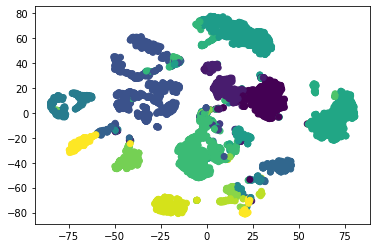

In [137]:
import matplotlib.pyplot as plt

plt.scatter(lat2d[:, 0], lat2d[:, 1], c=pred_lbls)

Hi Pierre,

Yes I would really appreciate that! 
I am having memory errors with the actual dataset, but I am not entirely sure about 
RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 31.72 GiB total capacity; 11.06 GiB already allocated; 15.56 MiB free; 494.74 MiB cached)
1. if it is also an issue with the lung benchmark data
2. if this error also occurs in the master branch of the scVI repo or just in the hierarchical branch in my repo (it does occur whether I set use_ontology to be false)  
The data I am using is this: /data/yosef2/users/chenling/TabulaSapiensData/combined/Pilot1_Pilot2.Final.h5ad, the column for batch is 'donor', and the column for label is 'manual_cell_ontology_class'. 
The code I am using is this: 

    scanvi = SCANVI(train_data.nb_genes, train_data.n_batches, train_data.n_labels, n_layers=3, n_latent=50,
                symmetric_kl=True, use_ontology=False, dispersion='gene-batch')

    trainer_scanvi = SemiSupervisedTrainer(scanvi, train_data,
                           n_epochs_classifier=50,
                           lr_classification=5 * 1e-3, seed=1,
                           n_epochs_kl_warmup=5) 

     

    unlabelled_idx = list(train_data.cell_types).index('unassigned')
    labelled = np.where(train_data.labels.ravel()!=unlabelled_idx)[0]
    unlabelled = np.where(train_data.labels.ravel()==unlabelled_idx)[0]

     

    model_file = '/data/yosef2/users/chenling/TabulaSapiens/scVImodels/combined/Pilot12.10X.donor.50.3.scVI.pkl'

    trainer_scanvi.model.load_state_dict(torch.load(model_file), strict=False)

    trainer_scanvi.model.eval()
    trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
    trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=unlabelled)
    trainer_scanvi.train(n_epochs=15)
     

Let me know if I am doing anything wrong? I tried this on two different aws instances and got the same memory error. Adam thinks it might be due to this part of the code. I meant to ask you after I test to see which version of scanvi gives the same error, but I think Nir wants it to be done asap. Sorry for dumping all of this work on you!

        y_probs = self.nodes_to_leaves_probs[y]

        leaves_batch = db.Categorical(probs=y_probs).sample() 

Thanks a lot! 
Best,
Chenling 